# **Introducción**

Para este proyecto, se decidió utilizar el dataset de Brain Tumor. Cómo se sabe, las personas con mejor tasa de recuperación de un cáncer cerebral son aquellas que pudieron ser diagnosticadas de manera temprana. Es por esto por lo que el enfoque de este proyecto es en la diagnosticación temprana de tumores cerebrales.

El área de la medicina es relevante en el área de la computación y de los modelos predictivos ya que ofrece la capacidad de entrenar modelos con características claras. Es decir; las CNN son capaces de aprender automáticamente características relevantes de las imágenes, sin necesidad de una extracción manual de características. También,  las CNN pueden aprender jerarquías de características, desde características simples a complejas, lo que es beneficioso para la detección de tumores.

# ***Datos***

In [1]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files

# Sube el archivo kaggle.json que descargaste
uploaded = files.upload()

# Mueve el archivo a la ubicación adecuada
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


Saving kaggle.json to kaggle.json


In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:01<00:00, 99.5MB/s]
100% 149M/149M [00:01<00:00, 127MB/s] 


In [5]:
!unzip brain-tumor-mri-dataset.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Traini

In [6]:
# Cargar datos utilizando image_dataset_from_directory
train_data_path = '/content/Training'
test_data_path = '/content/Testing'

img_size = (224, 244)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    image_size=img_size,
    batch_size=batch_size,
)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [7]:
train_df = pd.DataFrame({
    'filepaths': [str(path) for path in pathlib.Path(train_data_path).rglob("*.jpg")],
    'label': [path.parent.name for path in pathlib.Path(train_data_path).rglob("*.jpg")]
})

In [8]:
test_df = pd.DataFrame({
    'filepaths': [str(path) for path in pathlib.Path(test_data_path).rglob("*.jpg")],
    'label': [path.parent.name for path in pathlib.Path(test_data_path).rglob("*.jpg")]
})

In [9]:
# Dividir conjunto de prueba en validación y prueba
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

In [10]:
# Crear generadores de imágenes
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# **Desarrollo de Modelo**

In [11]:
model = Sequential()

# Primer bloque convolucional
model.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segundo bloque convolucional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercer bloque convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Cuarto bloque convolucional
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten para conectar a capas densas
model.add(Flatten())

# Capa densa con 256 neuronas y activación relu
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout para evitar el sobreajuste

# Capa de salida con activación softmax para la clasificación
model.add(Dense(len(train_df['label'].unique()), activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Muestra un resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 121, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 59, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 57, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 28, 128)       0

In [12]:
epochs = 5  # Ajusta el número de épocas según sea necesario

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n // batch_size
)


Epoch 1/5
357/357 [==============================] - 32s 53ms/step - loss: 1.3406 - accuracy: 0.7489 - val_loss: 0.5378 - val_accuracy: 0.8172
Epoch 2/5
357/357 [==============================] - 20s 56ms/step - loss: 0.3934 - accuracy: 0.8612 - val_loss: 0.4836 - val_accuracy: 0.8203
Epoch 3/5
357/357 [==============================] - 17s 48ms/step - loss: 0.3550 - accuracy: 0.8759 - val_loss: 0.3501 - val_accuracy: 0.8797
Epoch 4/5
357/357 [==============================] - 19s 52ms/step - loss: 0.2619 - accuracy: 0.9084 - val_loss: 0.2998 - val_accuracy: 0.8922
Epoch 5/5
357/357 [==============================] - 20s 55ms/step - loss: 0.2254 - accuracy: 0.9191 - val_loss: 0.2735 - val_accuracy: 0.9047


In [13]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'


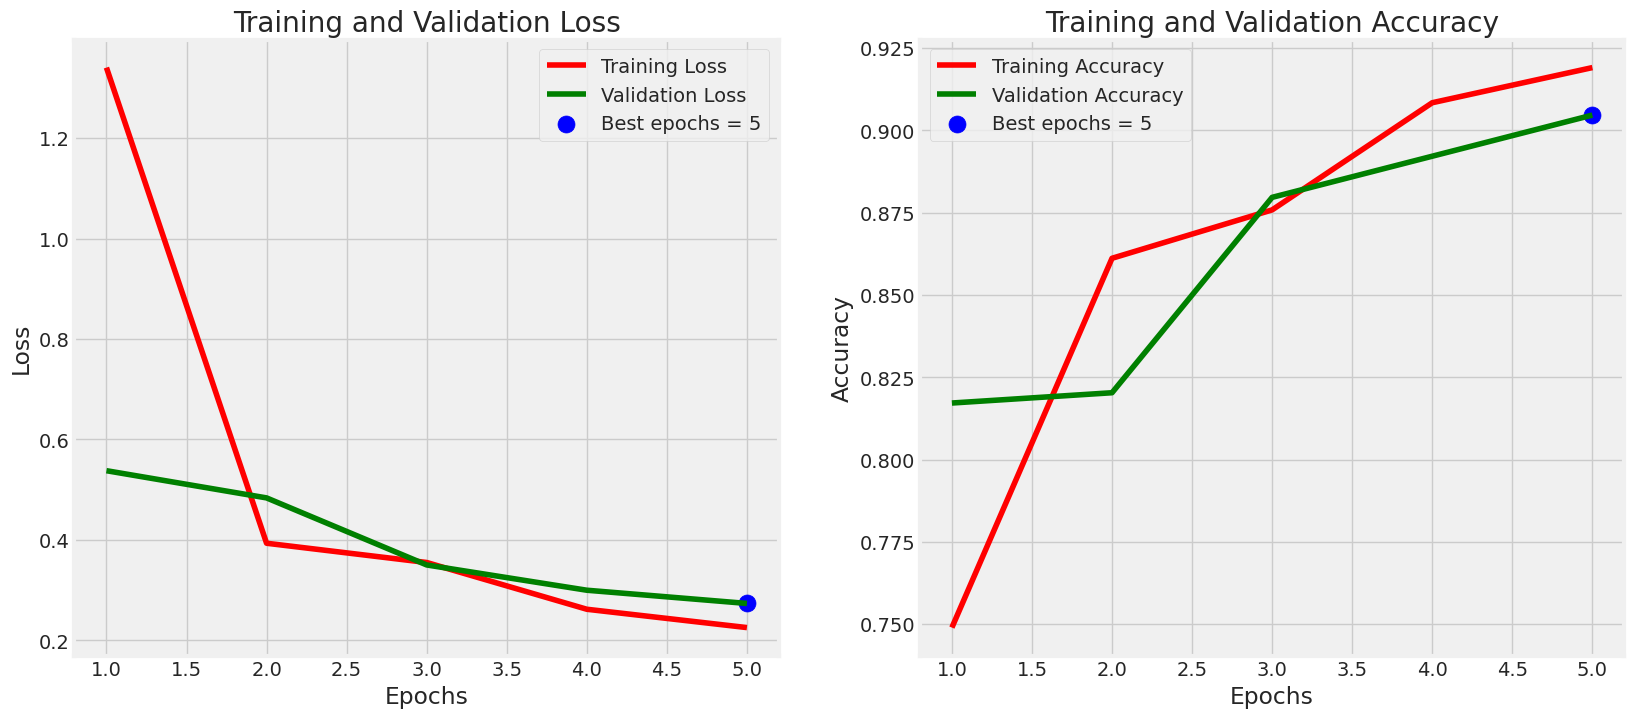

In [14]:

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# **Ajuste del Modelo**

Ya que el modelo tarda demasiado tiempo en correr, pienso que puede llegar a ser ineficiente y poco óptimo. Para esto, se decidió disminuir las capas de la red. También, se decidió cambiar y hacer un ajuste de otros hiperparámetros como el método de activación y la generación de Imagenes. En este segundo modelo, vamos vamos a cambiar la manera en la que generamos las imágenes. A pesar de que los resultados del primer modelo eran bastante buenos, queremos implementar algo que se tarde mucho menos.

Para esto, se cambió el tamaño de las imágenes, el tamaño del batch size, cambio en la capa de salida del modelo, y se aplicaron cambios en el optimizador y la tasa de aprendizaje.

In [15]:
# Ajustes para reducir el tiempo de entrenamiento
img_size = (128, 128)  # Reducir el tamaño de las imágenes
batch_size = 32  # Aumentar el tamaño del lote
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [16]:
# Ajustes para reducir el tiempo de entrenamiento en model2

from tensorflow.keras.layers import GlobalAveragePooling2D

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(GlobalAveragePooling2D())  # Global Average Pooling en lugar de capa densa
model2.add(Dropout(0.5))

model2.add(Dense(len(train_df['label'].unique()), activation='softmax'))

# Compilar el modelo
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
epochs = 15  # Ajusta el número de épocas según sea necesario

history = model2.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
)

Epoch 1/15
179/179 [==============================] - 14s 68ms/step - loss: 2.0291 - accuracy: 0.3916 - val_loss: 1.1276 - val_accuracy: 0.5344
Epoch 2/15
179/179 [==============================] - 13s 70ms/step - loss: 1.0807 - accuracy: 0.5205 - val_loss: 1.0801 - val_accuracy: 0.5450
Epoch 3/15
179/179 [==============================] - 12s 66ms/step - loss: 1.0124 - accuracy: 0.5816 - val_loss: 0.9931 - val_accuracy: 0.6458
Epoch 4/15
179/179 [==============================] - 12s 66ms/step - loss: 0.9658 - accuracy: 0.6099 - val_loss: 0.9567 - val_accuracy: 0.6641
Epoch 5/15
179/179 [==============================] - 12s 68ms/step - loss: 0.9366 - accuracy: 0.6255 - val_loss: 0.9530 - val_accuracy: 0.6672
Epoch 6/15
179/179 [==============================] - 12s 64ms/step - loss: 0.9250 - accuracy: 0.6257 - val_loss: 1.0073 - val_accuracy: 0.5405
Epoch 7/15
179/179 [==============================] - 11s 59ms/step - loss: 0.8829 - accuracy: 0.6544 - val_loss: 0.9591 - val_accuracy:

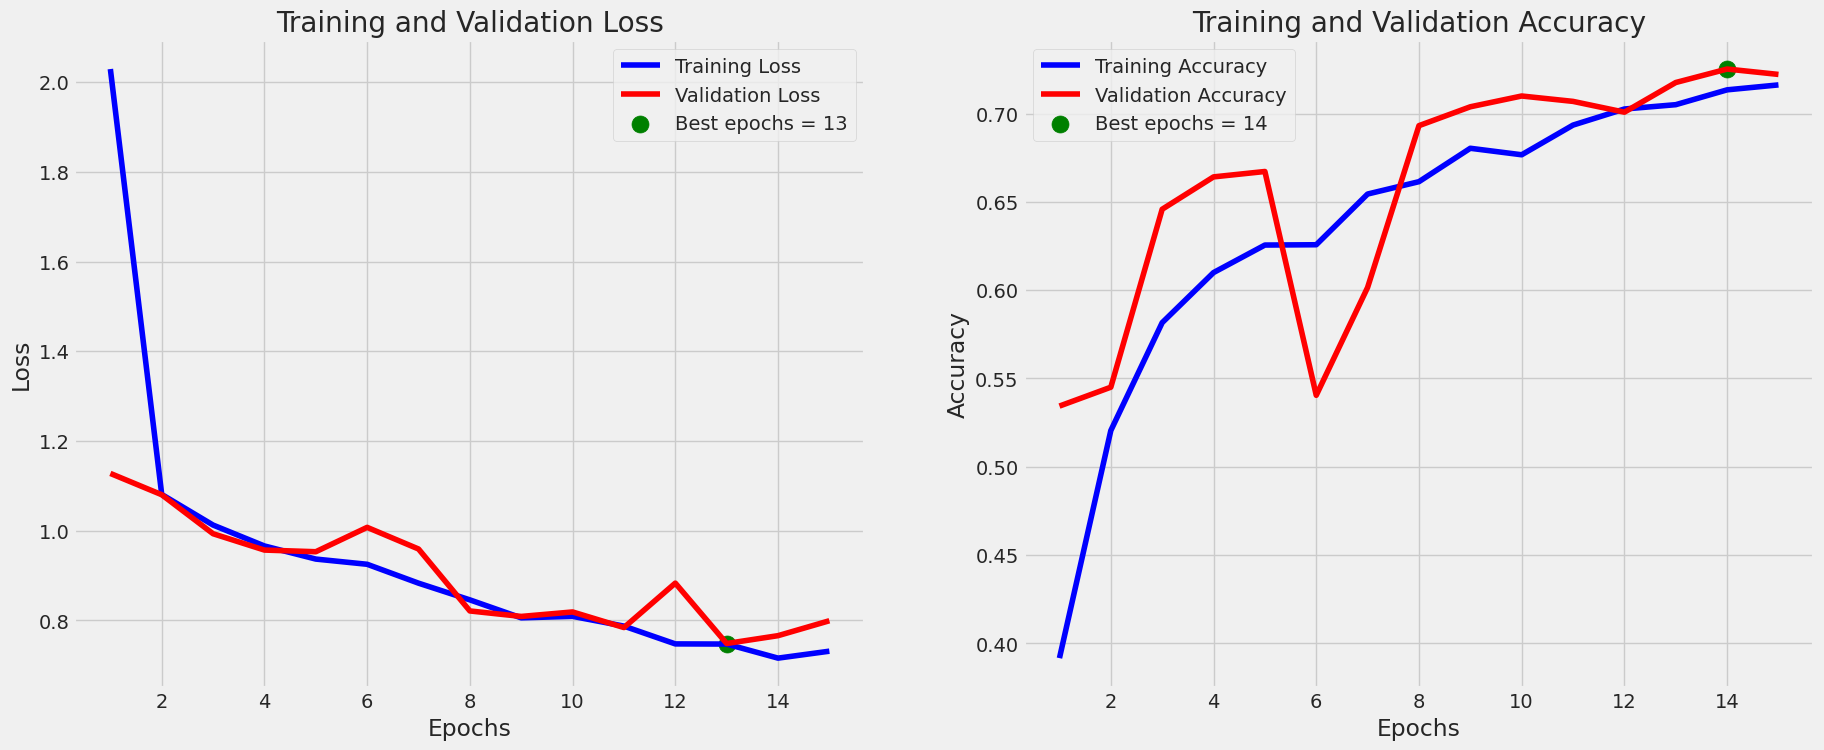

In [18]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'


plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'b' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'r' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'green',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'b' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'r' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'green',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

Finalmente, después de ver estos resultados, se decidió que lo mejor sería jugar con las capas y los hiperparámetros, respetando cómo se generaron las imágenes en el primer modelo. Esto se debe a que a pesar de que el modelo no tardó casi nada en correr, los resultados fueron mucho peores que el primer modelo.


In [19]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [20]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(len(train_df['label'].unique()), activation='softmax'))
# Compilar el modelo
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Muestra un resumen del modelo
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 121, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 59, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 203904)            0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [21]:
epochs = 5  # Ajusta el número de épocas según sea necesario

history = model3.fit(
    train_gen,
    steps_per_epoch=train_gen.n // batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n // batch_size
)

Epoch 1/5
357/357 [==============================] - 19s 49ms/step - loss: 11.2789 - accuracy: 0.7845 - val_loss: 0.4879 - val_accuracy: 0.8313
Epoch 2/5
357/357 [==============================] - 17s 47ms/step - loss: 0.3646 - accuracy: 0.8897 - val_loss: 0.3001 - val_accuracy: 0.9062
Epoch 3/5
357/357 [==============================] - 17s 48ms/step - loss: 0.1978 - accuracy: 0.9347 - val_loss: 0.2701 - val_accuracy: 0.9141
Epoch 4/5
357/357 [==============================] - 17s 47ms/step - loss: 0.2316 - accuracy: 0.9387 - val_loss: 0.4126 - val_accuracy: 0.8938
Epoch 5/5
357/357 [==============================] - 17s 47ms/step - loss: 0.1743 - accuracy: 0.9482 - val_loss: 0.3262 - val_accuracy: 0.9312


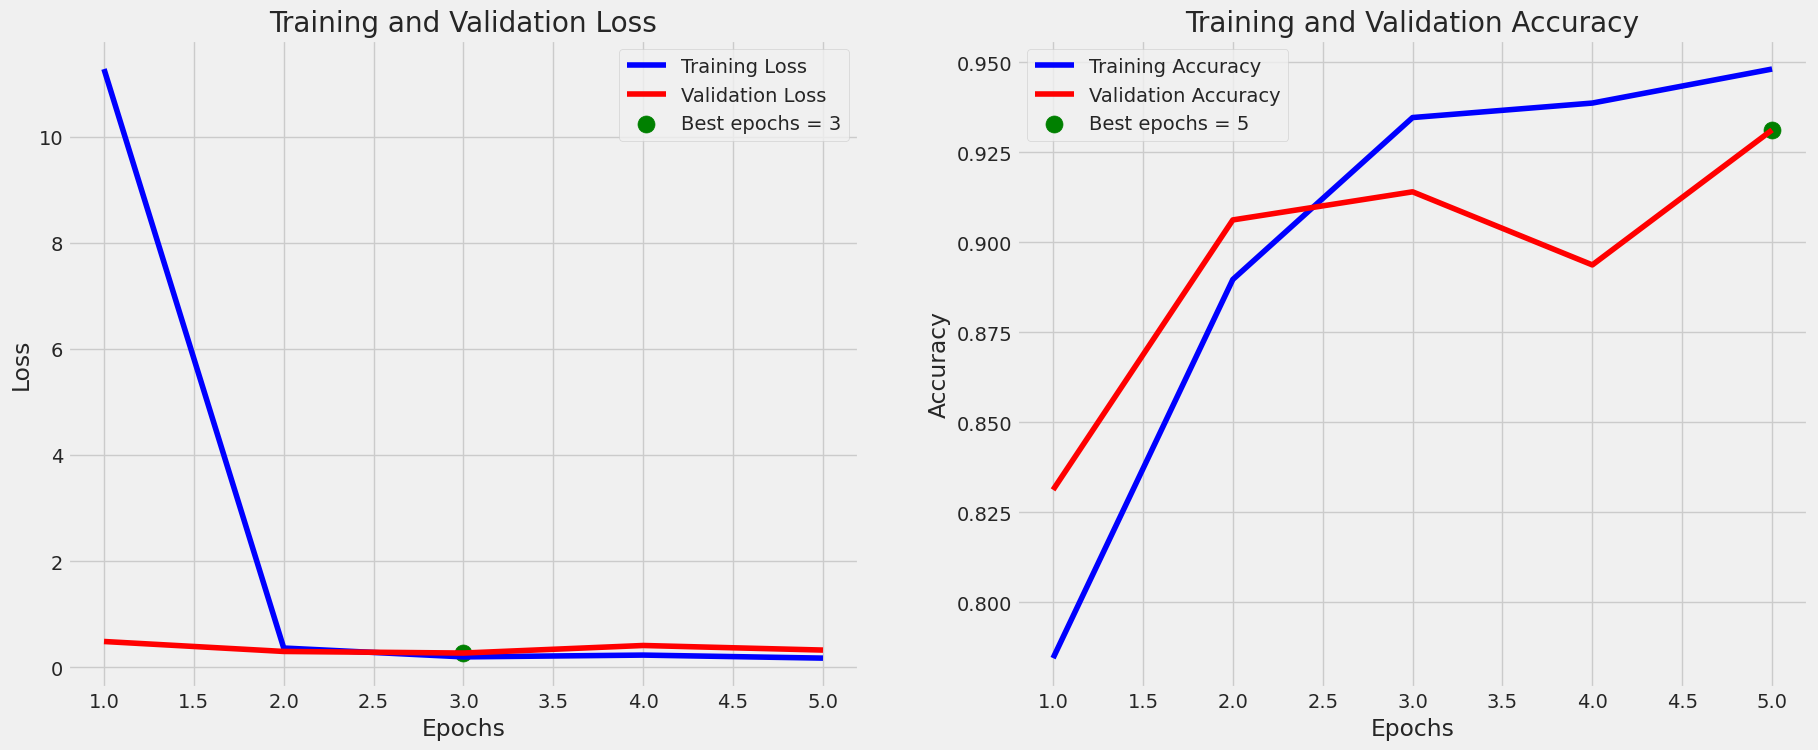

In [22]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'


plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'b' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'r' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'green',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'b' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'r' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'green',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# **Resultados**

In [23]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_gen, steps=test_gen.n // batch_size)
print(f"Loss: {evaluation[0]:.2f}")
print(f"Accuracy: {evaluation[1]:.2f}")


41/41 [==============================] - 2s 37ms/step - loss: 0.2421 - accuracy: 0.9024
Loss: 0.24
Accuracy: 0.90


In [24]:
# Evaluate the model on the test set
evaluation = model2.evaluate(test_gen, steps=test_gen.n // batch_size)
print(f"Loss: {evaluation[0]:.2f}")
print(f"Accuracy: {evaluation[1]:.2f}")

41/41 [==============================] - 1s 34ms/step - loss: 1.0587 - accuracy: 0.5701
Loss: 1.06
Accuracy: 0.57


In [25]:
# Evaluate the model on the test set
evaluation = model3.evaluate(test_gen, steps=test_gen.n // batch_size)
print(f"Loss: {evaluation[0]:.2f}")
print(f"Accuracy: {evaluation[1]:.2f}")

41/41 [==============================] - 1s 33ms/step - loss: 0.3078 - accuracy: 0.9223
Loss: 0.31
Accuracy: 0.92


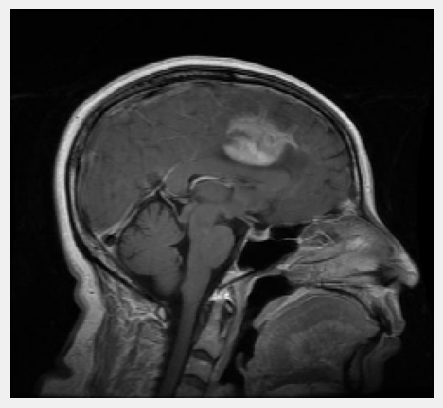

Etiqueta Verdadera: 0
1/1 [==============================] - 0s 261ms/step
Predicción del Modelo:  notumor


In [26]:
# Etiquetas posibles
labels = train_df['label'].unique()

# Muestra una imagen al azar del conjunto de prueba y su etiqueta
random_inx = np.random.choice(len(test_gen))
test_image, test_label = test_gen[random_inx]

# Cambiamos el orden de las dimensiones y añadimos la dimensión del lote
test_image_resized_model = cv2.resize(test_image[0], (244, 224))
test_image_resized_model_batched = np.expand_dims(test_image_resized_model, axis=0)

# Muestra la imagen correctamente
plt.axis('off')
plt.imshow(test_image_resized_model.squeeze().astype(np.uint8))
plt.show()

# Convertir la etiqueta codificada en one-hot a un escalar
true_label = np.argmax(test_label, axis=-1)
print(f"Etiqueta Verdadera: {test_gen.classes[true_label[0]]}")

# Predecir con el modelo
pred_model = model.predict(test_image_resized_model_batched)
predicted_label_model = labels[np.argmax(pred_model)]

print("Predicción del Modelo: ", predicted_label_model)




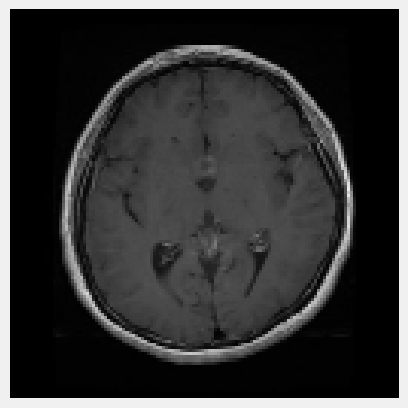

Etiqueta Verdadera: 2
1/1 [==============================] - 0s 115ms/step
Predicción del Modelo2:  meningioma


In [27]:
# Etiquetas posibles
labels = train_df['label'].unique()

# Muestra una imagen al azar del conjunto de prueba y su etiqueta
random_inx = np.random.choice(len(test_gen))
test_image, test_label = test_gen[random_inx]

# Redimensiona la imagen al tamaño esperado por el modelo2
test_image_resized = cv2.resize(test_image[0], (128, 128))

# Muestra la imagen correctamente
plt.axis('off')
plt.imshow(test_image_resized.astype(np.uint8))  # No es necesario llamar a .numpy() aquí
plt.show()

# Convertir la etiqueta codificada en one-hot a un escalar
true_label = np.argmax(test_label, axis=-1)
print(f"Etiqueta Verdadera: {test_gen.classes[true_label[0]]}")

# Obtener las predicciones del modelo
pred = model2.predict(np.expand_dims(test_image_resized, axis=0))
predicted_label = labels[np.argmax(pred)]

print("Predicción del Modelo2: ", predicted_label)


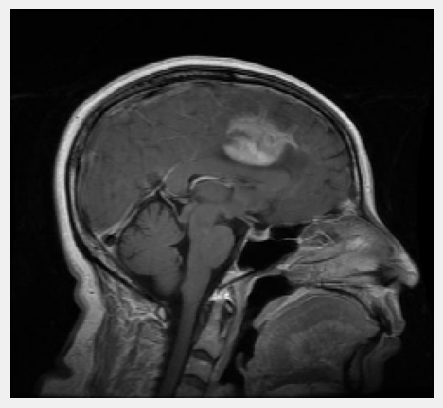

Etiqueta Verdadera: 0
1/1 [==============================] - 0s 63ms/step
Predicción del Modelo2:  notumor


In [28]:
# Choose a random test image

labels = train_df['label'].unique()

# Elegir una imagen de prueba al azar
random_inx = np.random.choice(len(test_gen))
test_image, test_label = test_gen[random_inx]

# Mostrar la imagen de prueba
plt.axis('off')
plt.imshow(test_image[0].astype(np.uint8))  # Asumiendo que es una imagen en escala de grises
plt.show()

# Convertir la etiqueta codificada en one-hot a un escalar
true_label = np.argmax(test_label, axis=-1)
print(f"Etiqueta Verdadera: {test_gen.classes[true_label[0]]}")

# Obtener las predicciones del modelo
pred_model = model2.predict(np.expand_dims(test_image[0], axis=0))
predicted_label_model = labels[np.argmax(pred_model)]

print("Predicción del Modelo2: ", predicted_label_model)


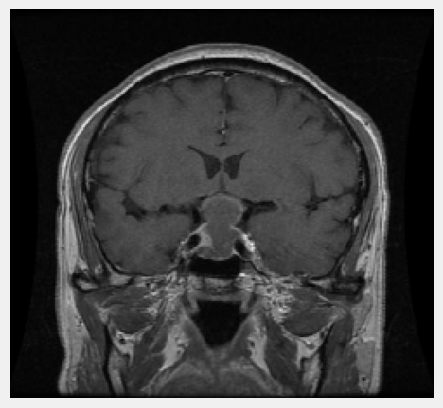

Etiqueta Verdadera: 2
1/1 [==============================] - 0s 69ms/step
Predicción del Modelo3:  glioma


In [29]:
# Choose a random test image

labels = train_df['label'].unique()

# Elegir una imagen de prueba al azar
random_inx = np.random.choice(len(test_gen))
test_image, test_label = test_gen[random_inx]

# Mostrar la imagen de prueba
plt.axis('off')
plt.imshow(test_image[0].astype(np.uint8))  # Asumiendo que es una imagen en escala de grises
plt.show()

# Convertir la etiqueta codificada en one-hot a un escalar
true_label = np.argmax(test_label, axis=-1)
print(f"Etiqueta Verdadera: {test_gen.classes[true_label[0]]}")

# Obtener las predicciones del modelo
pred_model = model3.predict(np.expand_dims(test_image[0], axis=0))
predicted_label_model = labels[np.argmax(pred_model)]

print("Predicción del Modelo3: ", predicted_label_model)



In [30]:
# Get the model predictions

pred_model = model.predict(np.expand_dims(test_image[0], axis=0))
predicted_label_model = labels[np.argmax(pred_model)]
print("Model: ", predicted_label)

1/1 [==============================] - 0s 20ms/step
Model:  meningioma


In [31]:
# Get the model predictions
pred_model = model2.predict(np.expand_dims(test_image[0], axis=0))
predicted_label_model = labels[np.argmax(pred_model)]
print("Model2: ", predicted_label)

1/1 [==============================] - 0s 21ms/step
Model2:  meningioma


In [32]:
# Get the model predictions
pred_model = model3.predict(np.expand_dims(test_image[0], axis=0))
predicted_label_model = labels[np.argmax(pred_model)]
print("Model: ", predicted_label)

1/1 [==============================] - 0s 31ms/step
Model:  meningioma


In [33]:
# Check model's predictions for each possible class
df = pd.DataFrame(pred, columns=train_df['label'].unique())
df



,meningioma,notumor,pituitary,glioma
0,0.451976,0.408308,0.052455,0.087261


<Axes: >

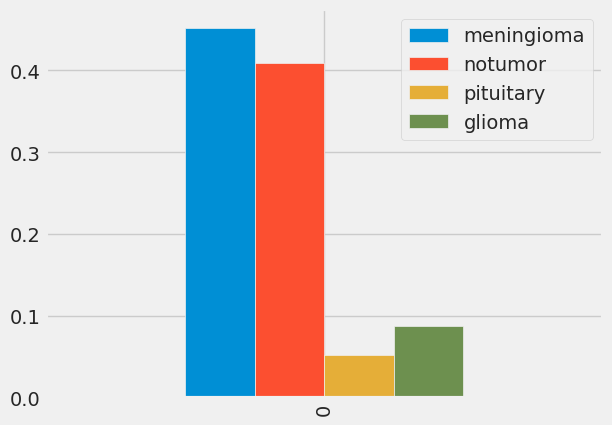

In [34]:
# Visualize model's predictions
df.plot.bar()

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict
predictions = model.predict(test_gen)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(true_labels, predicted_labels, target_names=labels)
print("Classification Report:\n", cr)


41/41 [==============================] - 1s 34ms/step
Confusion Matrix:
 [[121  23   2   3]
 [  7 125  14   8]
 [  1   3 205   0]
 [  0   3   0 141]]
Classification Report:
               precision    recall  f1-score   support

  meningioma       0.94      0.81      0.87       149
     notumor       0.81      0.81      0.81       154
   pituitary       0.93      0.98      0.95       209
      glioma       0.93      0.98      0.95       144

    accuracy                           0.90       656
   macro avg       0.90      0.90      0.90       656
weighted avg       0.90      0.90      0.90       656



In [36]:
from sklearn.metrics import confusion_matrix, classification_report

# Predicciones
predictions = model2.predict(test_gen)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes

# Matriz de confusion
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cm)

cr = classification_report(true_labels, predicted_labels, target_names=labels)
print("Classification Report:\n", cr)


41/41 [==============================] - 2s 46ms/step
Confusion Matrix:
 [[115  25   0   9]
 [ 62  39  22  31]
 [ 49  11 117  32]
 [ 31  10   0 103]]
Classification Report:
               precision    recall  f1-score   support

  meningioma       0.45      0.77      0.57       149
     notumor       0.46      0.25      0.33       154
   pituitary       0.84      0.56      0.67       209
      glioma       0.59      0.72      0.65       144

    accuracy                           0.57       656
   macro avg       0.58      0.58      0.55       656
weighted avg       0.61      0.57      0.56       656



In [37]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = model3.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cm)
cr = classification_report(true_labels, predicted_labels, target_names=labels)
print("Classification Report:\n", cr)


41/41 [==============================] - 1s 31ms/step
Confusion Matrix:
 [[123  23   1   2]
 [ 10 135   4   5]
 [  0   2 207   0]
 [  2   2   0 140]]
Classification Report:
               precision    recall  f1-score   support

  meningioma       0.91      0.83      0.87       149
     notumor       0.83      0.88      0.85       154
   pituitary       0.98      0.99      0.98       209
      glioma       0.95      0.97      0.96       144

    accuracy                           0.92       656
   macro avg       0.92      0.92      0.92       656
weighted avg       0.92      0.92      0.92       656



# **Conclusiones**

Después de todos estos modelos creados, podemos llegar a la conclusión de que el mejor modelo que obtuvimos fue el tercer modelo, el que tenía menores capas. Esto lo podemos verificar en las matrices de confusión, aunque puedo concluir de igual manera que este modelo está cerca del overfitting ya que tiene problemas para clasificar las imagenes que no tienen tumores.

Me parece que es importante recalcar que en primer instancia, podría parecer que el primer modelo y el último tienen resultados similares, sin embargo, debido a las capas, pudimos ver un mejor desempeño en este último.

Pienso que un área de oportunidad favorable podría ser que en lugar de una tasa de aprendizaje fija, se podría utilizar programadores de tasa de aprendizaje para ajustar la tasa de aprendizaje durante el entrenamiento. Esto puede ayudar a converger más rápido y alcanzar un óptimo mejor. También se podría implementar la detención temprana para prevenir el sobreajuste. Además, me parece que después de realizar algunos cambios sugeridos, la velocidad de la ejecución de los modelos no debería de ser un criterio tan importante, ya que como pudimos ver, el peor modelo fue el segundo, a pesar de que se implementó todo lo posible para obtener un modelo con ejecución más rápida.

En el segundo modelo, se trató de velocidad vs calidad. A pesar de que pudimos subir el número de epochs, se quedó muy lejos siquiera del primer modelo. Pienso que en un futuro, sería interesante comparar el último modelo con un RNN, para evaluar de manera experimental sus desempeños en el mismo data set.

# **Predicción con Nuevos Datos**

In [38]:
from tensorflow.keras.models import load_model

# Guardar el modelo en formato HDF5 (.h5)
model.save("/content/model3.h5")
model2.save("/content/model3.h5")
model3.save("/content/model3.h5")

Saving Te-gl_0015.jpg to Te-gl_0015.jpg
1/1 [==============================] - 0s 64ms/step


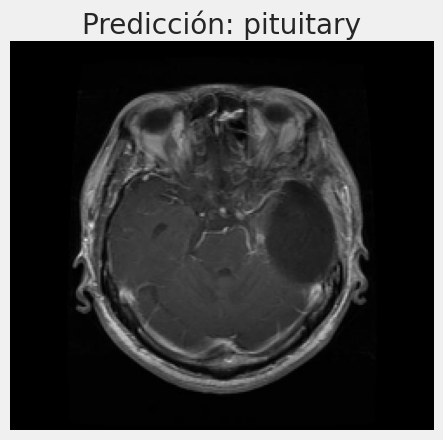

In [39]:
# Configuración de Google Colab para cargar imágenes
from google.colab import files

# Subir una imagen de ejemplo
uploaded = files.upload()

# Definir la ruta de la imagen cargada
uploaded_file_path = next(iter(uploaded))

# Función para realizar predicciones con nuevos datos
def predict_new_data(model, image_path):
    # Cargar la imagen y preprocesarla
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img / 255.0  # Normalizar la imagen

    # Realizar la predicción
    img_batch = np.expand_dims(img, axis=0)
    prediction = model.predict(img_batch)

    # Obtener la etiqueta predicha
    predicted_label = labels[np.argmax(prediction)]

    # Mostrar la imagen y la predicción
    plt.imshow(img)
    plt.title(f'Predicción: {predicted_label}')
    plt.axis('off')
    plt.show()

# Cargar el modelo previamente entrenado
model3 = load_model('/content/model3.h5')  # Asegúrate de tener el modelo guardado

# Ruta del modelo
model_path = '/content/model3.h5'

# Ejemplo de uso con la imagen cargada en Colab
predict_new_data(model3, uploaded_file_path)